# Import Packages

In [5]:
import pandas as pd
import numpy as np
import pmdarima as pm
from datetime import datetime, date
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARIMA

ImportError: DLL load failed while importing _smoothers_lowess: The filename or extension is too long.

#### Load Data


In [5]:
szn_df = pd.read_csv('Aquifer_Petrignano.csv')
szn_df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


# EDA

In [6]:
# Remove old rows
szn_df= szn_[szn_df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
# Remove not usefull columns
szn_df = szn_df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

In [7]:
# Simplify column names
df.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']

targets = ['depth_to_groundwater']
features = [feature for feature in df.columns if feature not in targets]
df.head()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


In [8]:


df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y')
df.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'})

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


# DATA VISUALIZATION


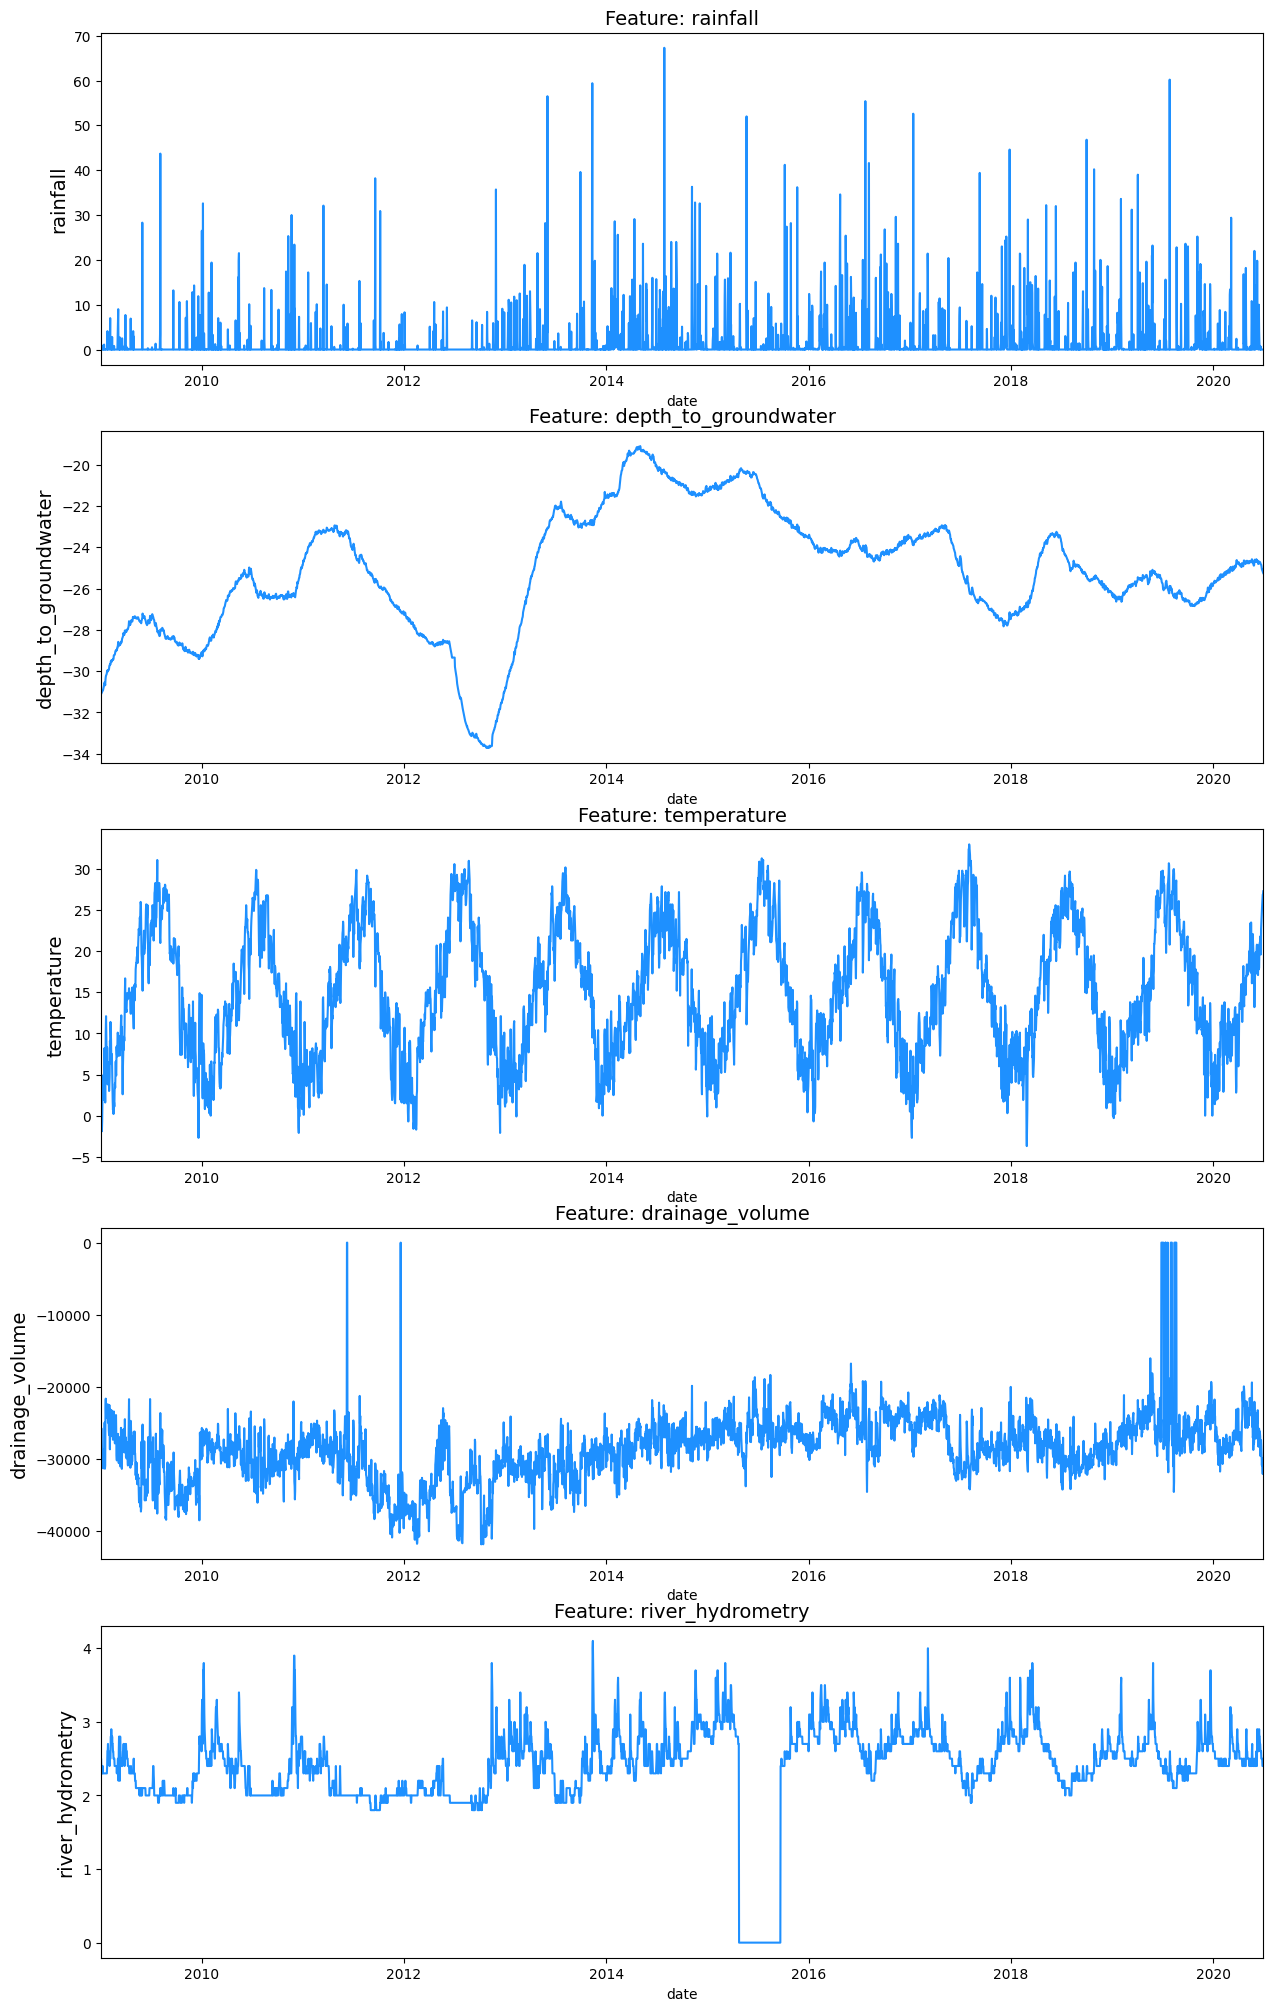

In [17]:
# To complete the data, as naive method, we will use ffill
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

for i, column in enumerate(df.drop('date', axis=1).columns):
    sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
                      
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])    

In [10]:
df = df.sort_values(by='date')

# Check time intervals
df['delta'] = df['date'] - df['date'].shift(1)

df[['date', 'delta']].head()

,date,delta
0,2009-01-01,NaT
1,2009-01-02,1 days
2,2009-01-03,1 days
3,2009-01-04,1 days
4,2009-01-05,1 days


In [11]:
df['delta'].sum(), df['delta'].count()

(Timedelta('4198 days 00:00:00'), 4198)

In [12]:
df = df.drop('delta', axis=1)
df.isna().sum()

date                     0
rainfall                 0
depth_to_groundwater    27
temperature              0
drainage_volume          1
river_hydrometry         0
dtype: int64

(14245.0, 18443.0)

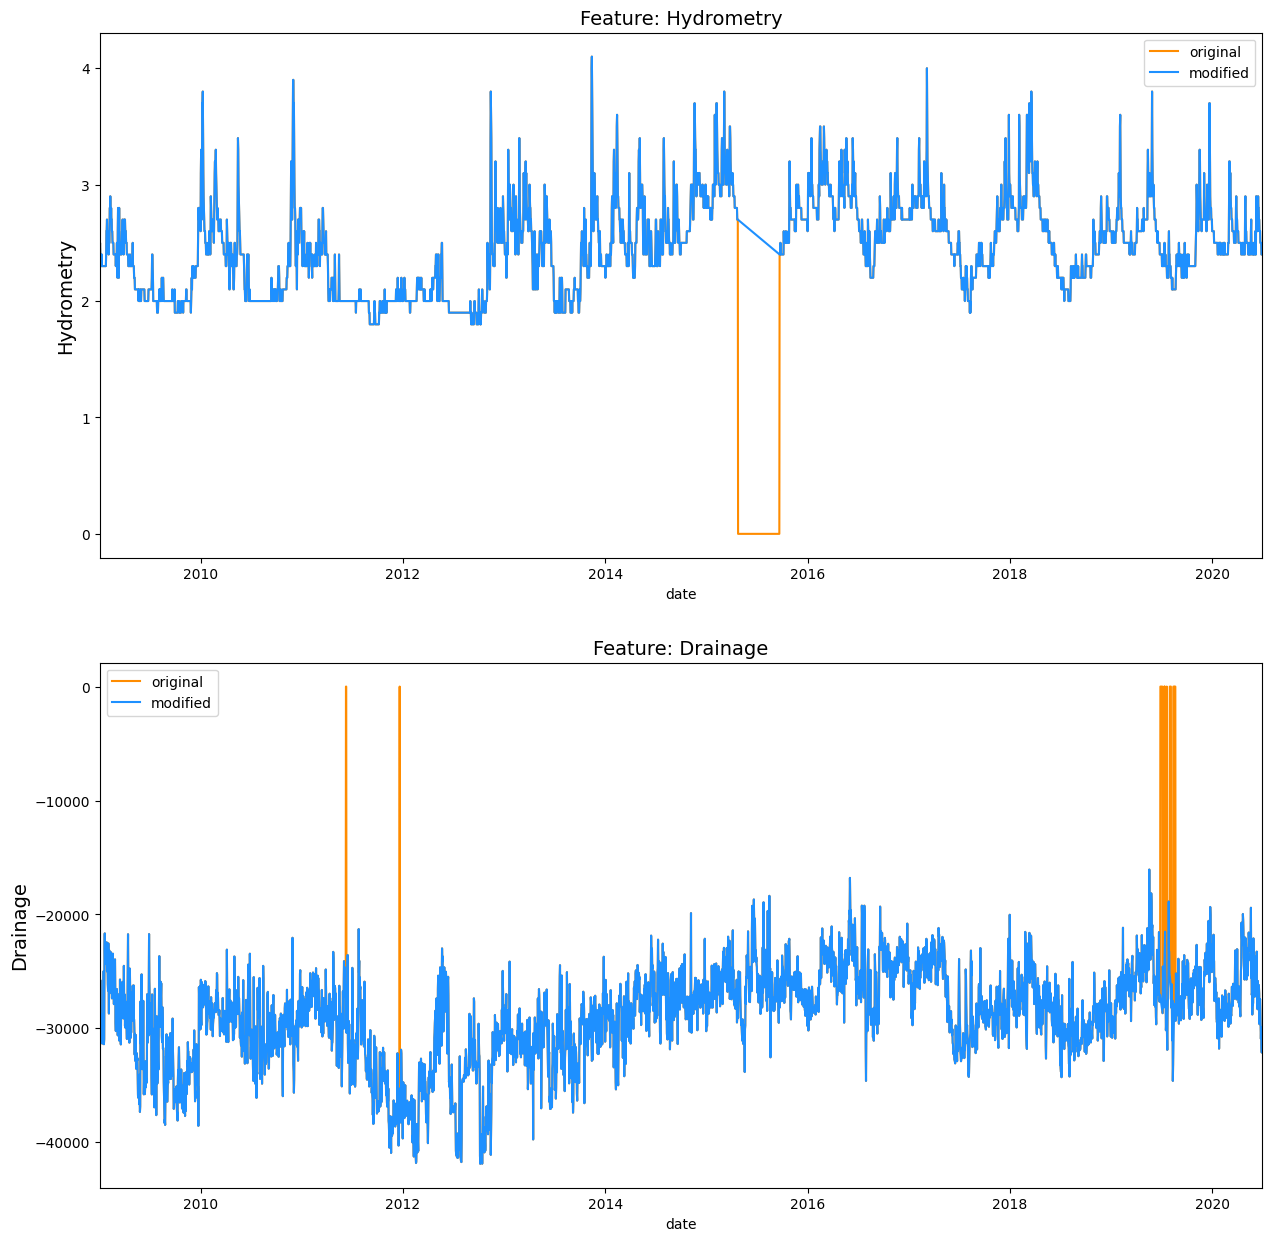

In [18]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

old_hydrometry = df['river_hydrometry'].copy()
df['river_hydrometry'] = df['river_hydrometry'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_hydrometry, ax=ax[0], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['river_hydrometry'].fillna(np.inf), ax=ax[0], color='dodgerblue', label='modified')
ax[0].set_title('Feature: Hydrometry', fontsize=14)
ax[0].set_ylabel(ylabel='Hydrometry', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

old_drainage = df['drainage_volume'].copy()
df['drainage_volume'] = df['drainage_volume'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_drainage, ax=ax[1], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[1], color='dodgerblue', label='modified')
ax[1].set_title('Feature: Drainage', fontsize=14)
ax[1].set_ylabel(ylabel='Drainage', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

Investigate missing values

<ipython-input-19-9443968911d8>:7: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)


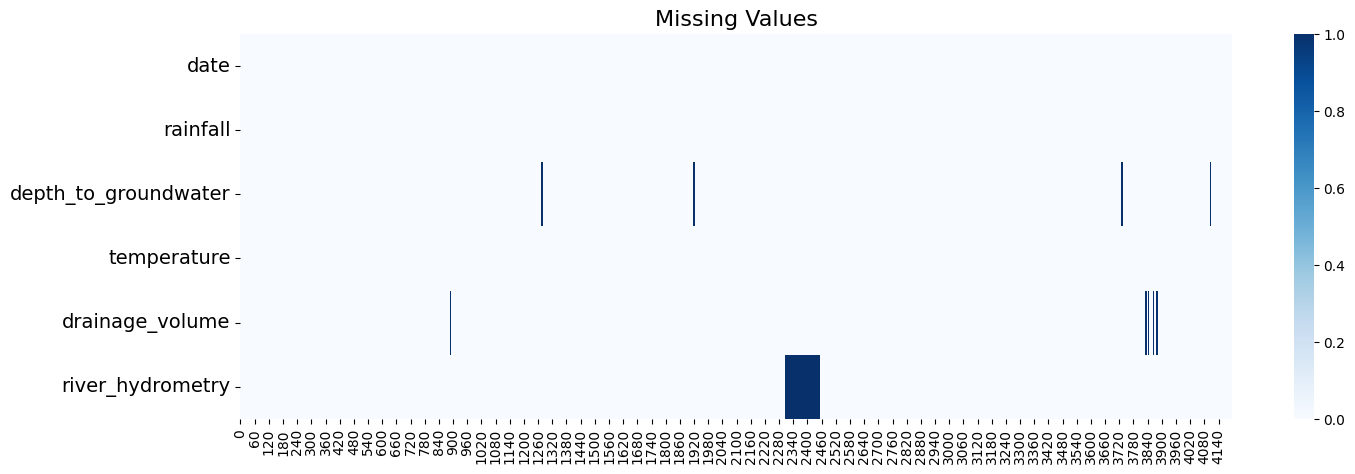

In [19]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Missing Values', fontsize=16)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

In [20]:
df['drainage_volume'] = df['drainage_volume'].interpolate()
df['river_hydrometry'] = df['river_hydrometry'].interpolate()
df['depth_to_groundwater'] = df['depth_to_groundwater'].interpolate()

In [23]:
# As we can see, downsample to weekly could smooth the data and help with analysis
downsample = df[['date',
                 'depth_to_groundwater', 
                 'temperature',
                 'drainage_volume', 
                 'river_hydrometry',
                 'rainfall'
                ]].resample('7D', on='date').mean().reset_index(drop=False)

df = downsample.copy()

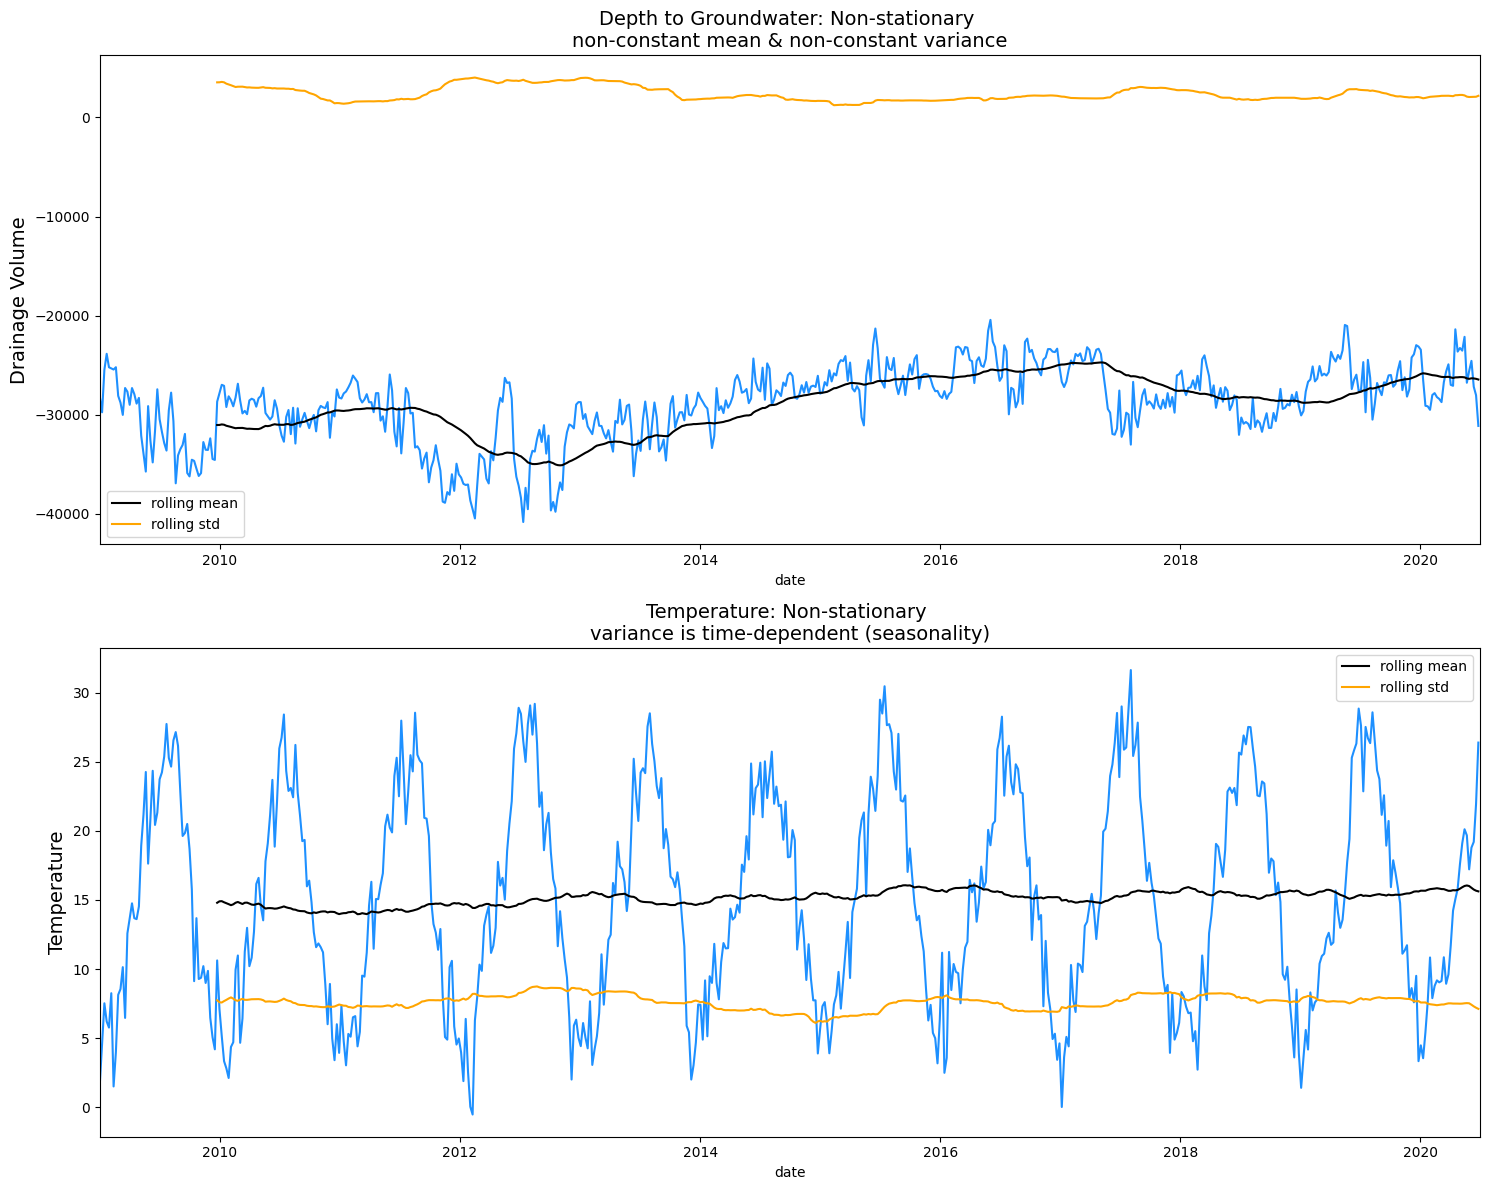

In [24]:
# A year has 52 weeks (52 weeks * 7 days per week) aporx.
rolling_window = 52
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['drainage_volume'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('Depth to Groundwater: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0].set_ylabel(ylabel='Drainage Volume', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(x=df['date'], y=df['temperature'], ax=ax[1], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('Temperature: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

In [25]:


result = adfuller(df['depth_to_groundwater'].values)
result

(-2.8802016493166605,
 0.047699190920208856,
 7,
 592,
 {'1%': -3.441444394224128,
  '5%': -2.8664345376276454,
  '10%': -2.569376663737217},
 -734.3154255877616)

In [28]:


N_SPLITS = 3

X = df['date']
y = df['depth_to_groundwater']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

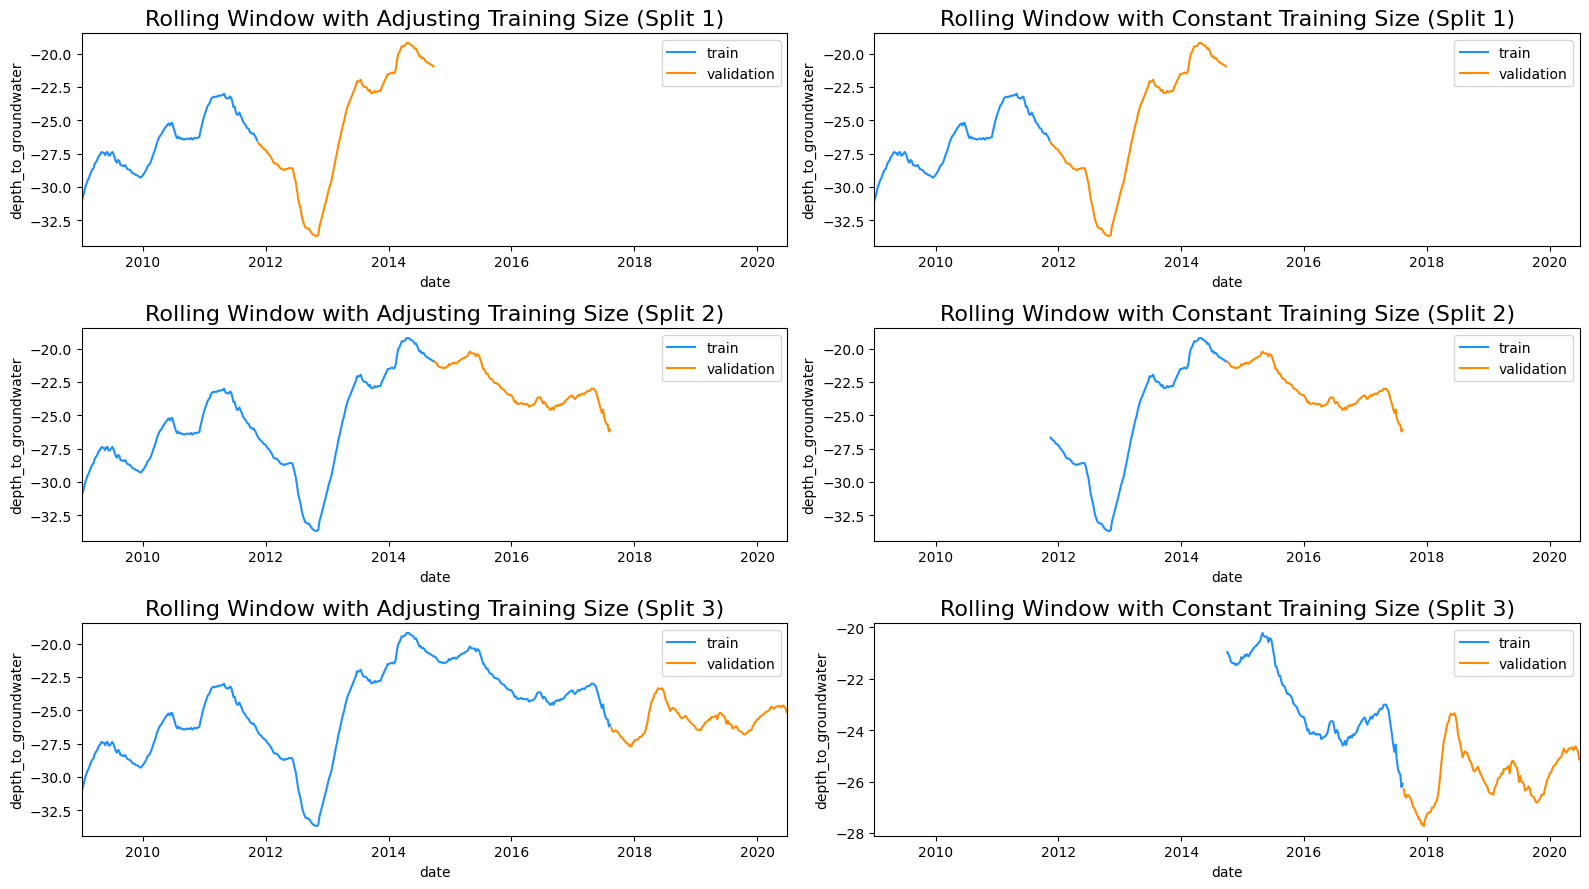

In [52]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='dodgerblue', 
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        ax=ax[i,1], 
        color='dodgerblue', 
        label='train'
    )
    for j in range(2):
            sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
            ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
            ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
            ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
            ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
          
plt.tight_layout()
plt.show()

Models for Univariate Time Series

In [56]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size

univariate_df = df[['date', 'depth_to_groundwater']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

510 90


ARIMA

In [65]:
# Fit model
model = ARIMA(y_train, order=(1,1,1))
model_fit = model.fit()

# Prediction with ARIMA
y_pred = model_fit.forecast(90)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print('RMSE: {}'.format(score_rmse))

RMSE: 1.402615843711107


In [68]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.6 MB/s eta 0:00:00


In [69]:


model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-631.136, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-242.692, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-574.047, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-427.347, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-243.054, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-629.209, Time=2.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-629.237, Time=2.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-492.779, Time=0.69 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-611.065, Time=0.69 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-628.351, Time=3.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-632.995, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-428.258, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-575.735, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-631.069, Time=2.25 sec
 ARIMA(1,1,2)(0,0,0)[0]          

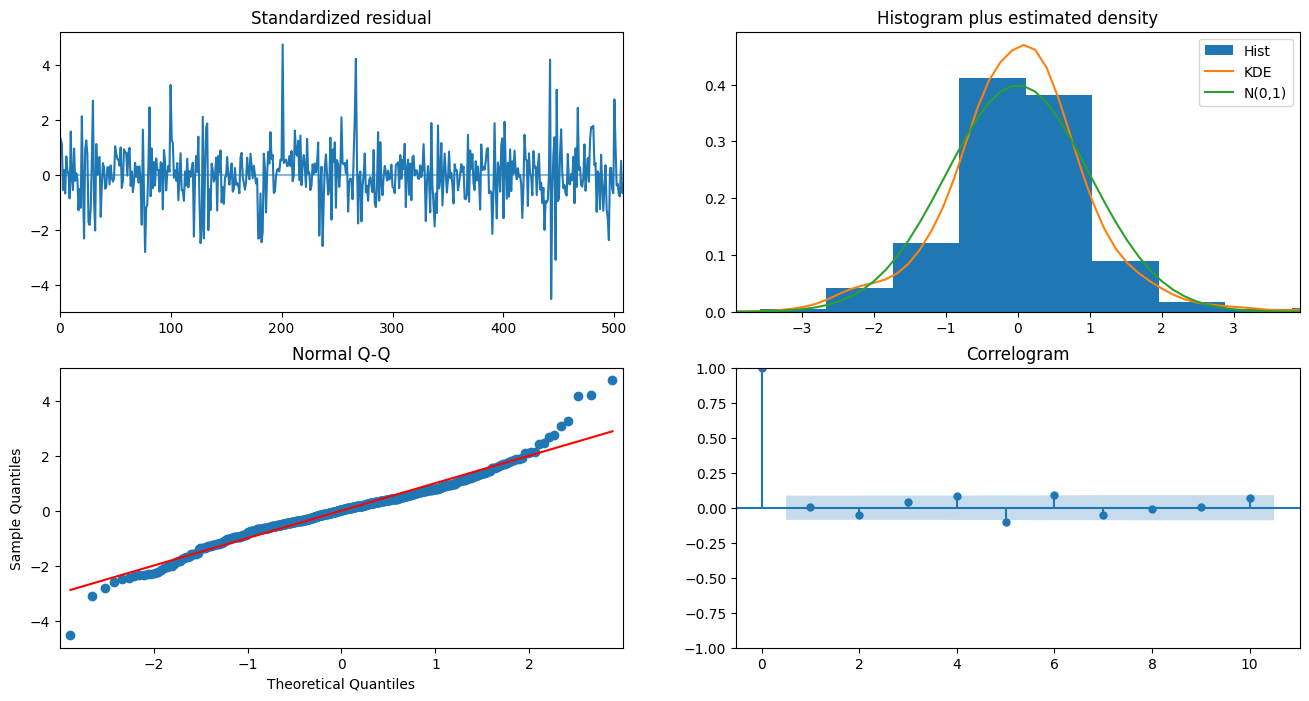

In [70]:
model.plot_diagnostics(figsize=(16,8))
plt.show()